In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import json

import torch

from sklearn.metrics.pairwise import cosine_similarity

from sentence_transformers import SentenceTransformer

In [ ]:
MEMBER_TO_REFERRALS_FP = 'data/process/member_to_referrals_received_75_10000.json'

In [90]:
def load_member_data(file_path: str) -> pd.DataFrame:
    """
    Load member data from a JSON file and convert it to a DataFrame

    Args:
        file_path (str) - The path to the JSON file

    Returns:
        data - The loaded data as a DataFrame
    """
    with open(file_path, 'r') as f:
        data = json.load(f)

    rows = [(name, referral) for name, referrals in data.items() for referral in referrals]

    member_df = pd.DataFrame(rows, columns = ['name', 'referral_received'])

    return member_df

In [ ]:
member_df = load_member_data(MEMBER_TO_REFERRALS_FP)

print(member_df.head())

     name                                  referral_received
0  joshua  met during a class we both hated — joshua made...
1  joshua  ran a summer program with joshua and every int...
2  joshua  even when nothing’s going right, joshua knows ...
3  joshua  met because we were both tagged in a chaotic e...
4  joshua  met because of a group dinner — by dessert, jo...


In [92]:
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

embeddings = model.encode(
    member_df['referral_received'].tolist(), 
    convert_to_tensor = True,
    batch_size = 64,
    show_progress_bar = True
)

member_df['rr_embedding'] = [embedding.cpu().numpy() for embedding in embeddings]

print(member_df.head())

/Users/paul/opt/miniconda3/envs/env/lib/python3.12/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Batches: 100%|██████████| 162/162 [00:13<00:00, 12.41it/s]


     name                                  referral_received  \
0  joshua  met during a class we both hated — joshua made...   
1  joshua  ran a summer program with joshua and every int...   
2  joshua  even when nothing’s going right, joshua knows ...   
3  joshua  met because we were both tagged in a chaotic e...   
4  joshua  met because of a group dinner — by dessert, jo...   

                                        rr_embedding  
0  [0.017458364, 0.078958295, -0.0052679493, -0.0...  
1  [-0.0020363915, 0.060987283, -0.020633744, -0....  
2  [-0.031102246, 0.072391935, -0.007732357, -0.0...  
3  [0.035717037, 0.040802315, -0.0045732255, 0.00...  
4  [0.0063147615, 0.041570205, -0.025905373, -0.0...  


In [ ]:
grouped_embeddings = member_df.groupby('name')['rr_embedding']

mean_pooled_referral_embeddings = grouped_embeddings.mean().reset_index(name = 'mean_embedding')
referral_counts = grouped_embeddings.count().reset_index(name = 'referral_count')

with open('data/process/human_embeddings.json', 'w') as f:
    json.dump(
        dict(zip(mean_pooled_referral_embeddings['name'], 
                 mean_pooled_referral_embeddings['mean_embedding'].apply(lambda x: x.tolist()))),
        f,
        indent = 2
    )

print(mean_pooled_referral_embeddings, end = '\n\n')
print(referral_counts)

        name                                     mean_embedding
0    abigail  [-0.005698122, 0.064108685, -0.004689344, 0.01...
1    allison  [-0.0187301, 0.08976166, -0.017098963, -0.0123...
2      amber  [0.036621604, 0.013988284, -0.005779304, 0.012...
3        amy  [0.0045502107, 0.039141938, -0.018259015, -0.0...
4     angela  [-0.0088246185, 0.037121426, -0.022356525, 0.0...
..       ...                                                ...
70    tricia  [0.019097408, -0.008826812, 0.0023819446, -0.0...
71  victoria  [-0.0055460907, 0.011007067, -0.0027549888, -0...
72   whitney  [-0.0061633154, 0.058006626, -0.006751578, 0.0...
73   william  [-0.0061818794, 0.05225764, -0.008076924, -0.0...
74   zachary  [-0.001026334, 0.060574457, -0.018364405, 0.00...

[75 rows x 2 columns]

        name  referral_count
0    abigail             146
1    allison             141
2      amber             133
3        amy             119
4     angela             136
..       ...             ...
70   

In [94]:
names = mean_pooled_referral_embeddings['name'].tolist()
mean_embeddings = np.array(mean_pooled_referral_embeddings['mean_embedding'].tolist())

similarity_matrix = cosine_similarity(mean_embeddings)

similarity_df = pd.DataFrame(similarity_matrix, index = names, columns = names)
np.fill_diagonal(similarity_df.values, np.nan)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


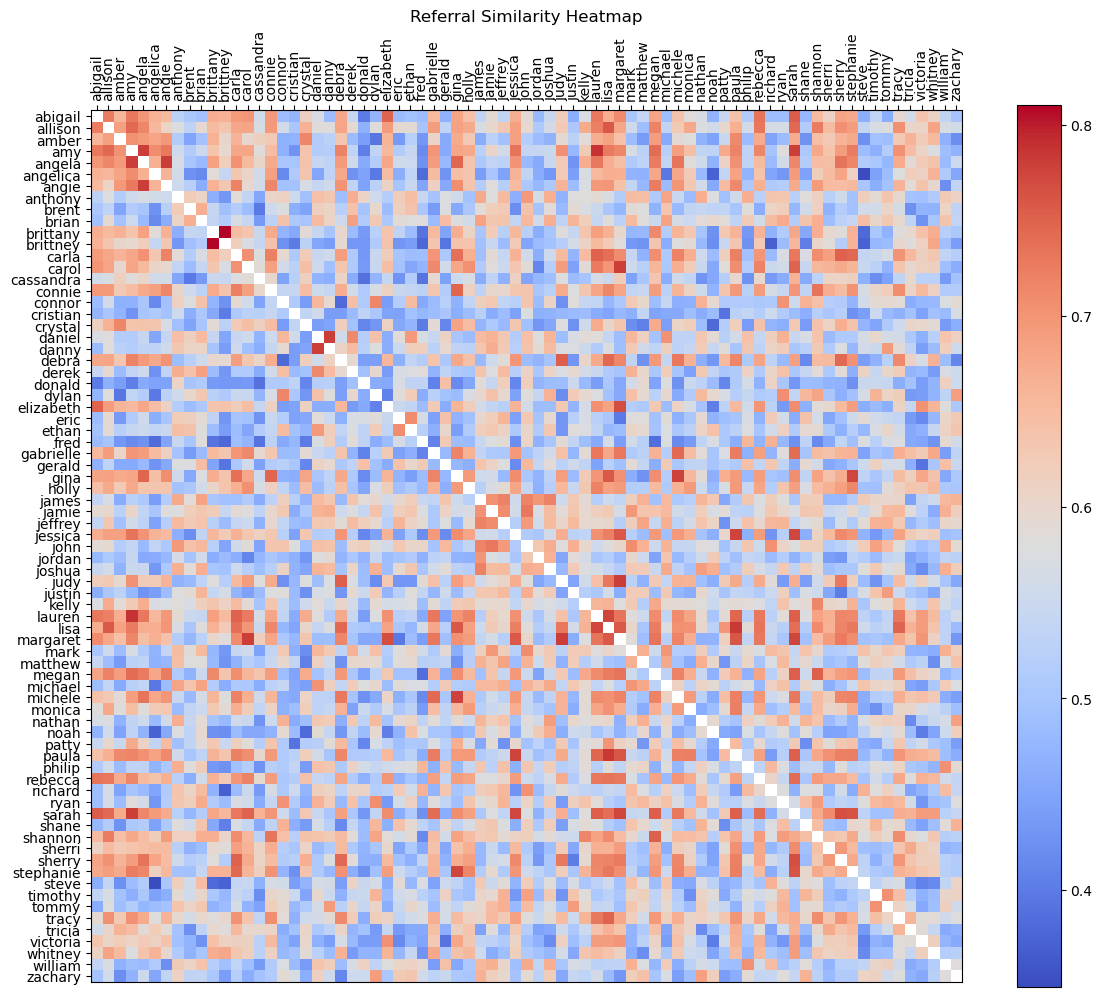

In [ ]:
plt.figure(figsize = (12, 10))
plt.imshow(similarity_matrix, cmap = 'coolwarm')
plt.xticks(ticks = np.arange(len(names)), labels = names, rotation = 90)
plt.yticks(ticks = np.arange(len(names)), labels = names)
plt.gca().xaxis.tick_top()
plt.title('Referral Similarity Heatmap')
plt.colorbar()
plt.tight_layout()
plt.savefig('data/postprocess/referral_similarity_heatmap.png')
plt.show()

In [96]:
def get_top_k_matches(sim_df: pd.DataFrame, k = 3):
    matches = {}
    for name in sim_df.index:
        top = sim_df.loc[name].nlargest(k)
        matches[name] = list(top.index)
    return matches

top_matches = pd.DataFrame(get_top_k_matches(similarity_df, k = 3))

print(top_matches)

     abigail allison    amber     amy angela angelica   angie  anthony  brent  \
0      sarah    lisa  crystal  lauren    amy      amy  angela     john  brian   
1  elizabeth   sarah    paula  angela  angie    sarah     amy  michael  derek   
2    rebecca     amy      amy   sarah   gina   connie   megan    james   john   

     brian  ... stephanie    steve  timothy    tommy   tracy  tricia  \
0    derek  ...      gina  richard    tommy  timothy    lisa  sherri   
1  michael  ...     sarah    brian     john    danny  lauren   paula   
2    james  ...     carla     mark  jeffrey   justin   debra   sarah   

    victoria   whitney william zachary  
0  elizabeth     sarah  philip   dylan  
1   margaret   allison    john  nathan  
2      sarah  brittney  joshua   shane  

[3 rows x 75 columns]
